# Exercise 1:

Using frame.png, make the frame straight and print the input/output images

In [1]:
import requests
import cv2
from matplotlib import pyplot as plt 
import numpy as np

from utils import *

In [5]:
from matplotlib.backend_bases import MouseButton
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

image = cv2.imread('data/images/frame.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)
pts = plt.ginput(4,show_clicks=True, mouse_add=MouseButton.LEFT, mouse_pop=MouseButton.RIGHT, mouse_stop=MouseButton.MIDDLE) 
plt.close()

C:\Users\ronyf\AppData\Local\Temp\ipykernel_19044\2244809339.py:3: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed two minor releases later.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use('TkAgg')


In [6]:
print(pts)

[(222.7258064516129, 180.04838709677415), (422.7258064516129, 179.4032258064516), (247.24193548387095, 500.0483870967742), (454.3387096774194, 458.11290322580646)]


In [7]:
input_pts = np.array(pts, dtype=np.float32)
width = (np.linalg.norm(input_pts[0]-input_pts[1]), np.linalg.norm(input_pts[2]-input_pts[3]))
height = (np.linalg.norm(input_pts[0]-input_pts[2]), np.linalg.norm(input_pts[1]-input_pts[3]))
width = int(np.max(width))
height = int(np.max(height))

output_pts = np.array([(0, 0),
          (width-1, 0),
          (0, height-1),
          (width-1,height-1)], np.float32)

In [8]:
H = cv2.getPerspectiveTransform(input_pts, output_pts) 

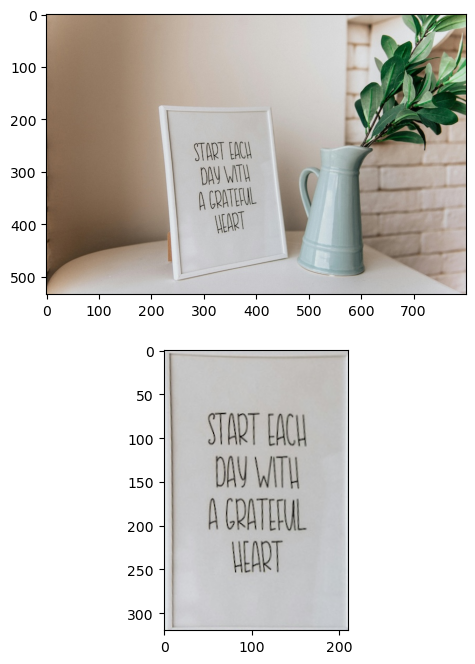

In [9]:
output_image = cv2.warpPerspective(image, H, (width, height), flags=cv2.INTER_LINEAR)


# Display the original and transformed images
%matplotlib inline
plt.figure(figsize = (10,8))
plt.subplot(211)
plt.imshow( image)
plt.subplot(212)
plt.imshow( output_image)

# Exercise 2: 
Stitch the images keble.000.png and keble.003.png

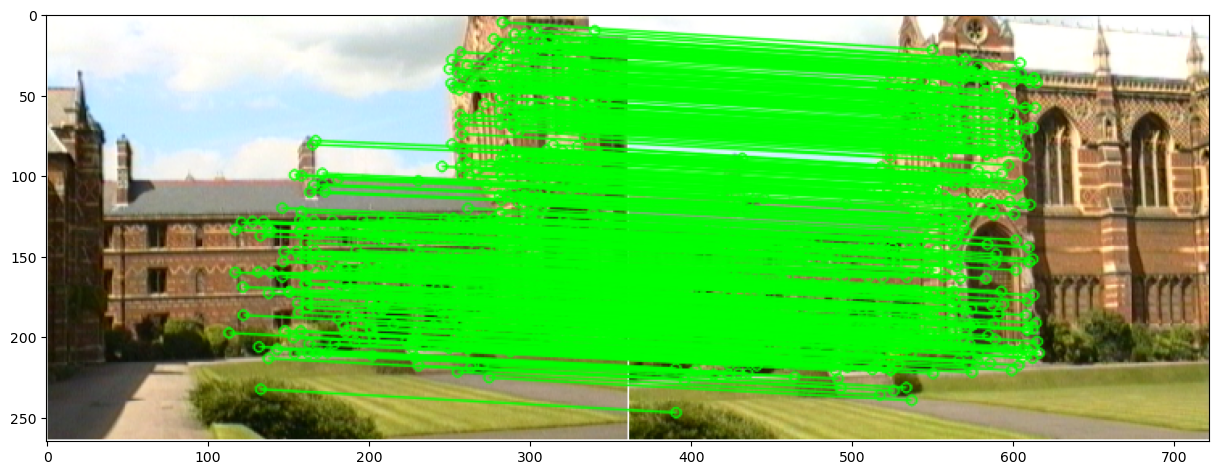

(<matplotlib.image.AxesImage at 0x24b2f4d8150>, None)

In [44]:
img0 = cv2.imread('data/images/keble.000.png')
img1 = cv2.imread('data/images/keble.003.png')

feat = cv2.SIFT_create()

# Find the keypoints and descriptors with ORB
kp1, des1 = feat.detectAndCompute(img0, None)
kp2, des2 = feat.detectAndCompute(img1, None)

# Create BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

# Extract the matched keypoints
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

# Use RANSAC to estimate the homography matrix
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=5)

# Draw the matching 
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = mask.ravel().tolist(), # draw only inliers
                   flags = 2)
plt.figure(figsize=(15,15))
output_image = cv2.drawMatches(img0,kp1,img1,kp2,good,None,**draw_params)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)), plt.show()

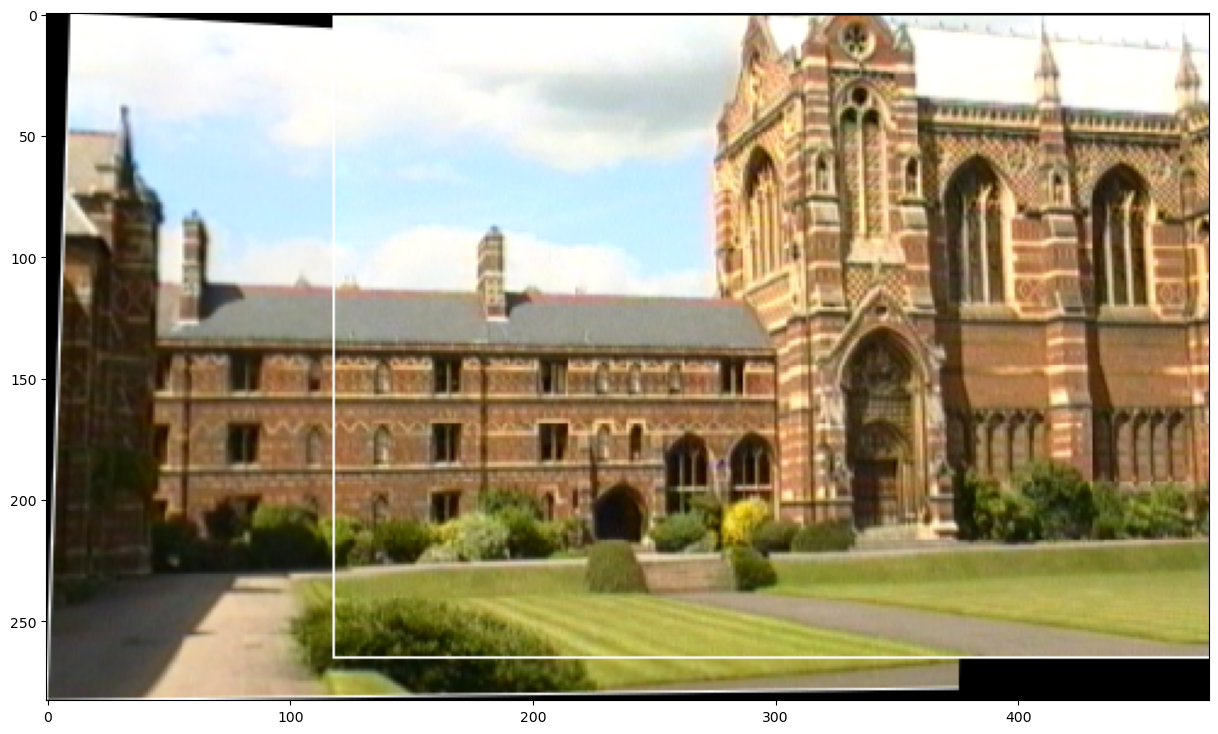

In [45]:
# Find the corners of the transformed image
h1, w1 = img0.shape[:2]
h2, w2 = img1.shape[:2]
corners1 = np.array([[0, 0], [0, h1 - 1], [w1 - 1, h1 - 1], [w1 - 1, 0]], dtype=np.float32).reshape(-1, 1, 2)
corners2 = np.array([[0, 0], [0, h2 - 1], [w2 - 1, h2- 1], [w2 - 1, 0]], dtype=np.float32).reshape(-1, 1, 2)

transformed_corners = cv2.perspectiveTransform(corners1, H) # only corners 1 undergo transformation
transformed_corners = np.concatenate((transformed_corners, corners2), axis=0)

# Find the minimum and maximum coordinates to get the dimensions of the panoramic image
min_x, min_y = np.int32(transformed_corners.min(axis=0).ravel())
max_x, max_y = np.int32(transformed_corners.max(axis=0).ravel())

# Adjust the homography matrix to account for the shift
translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
adjusted_homography_matrix = np.dot(translation_matrix, H)

# Apply the adjusted homography to warp the image
stitched_image = cv2.warpPerspective(img0, adjusted_homography_matrix, (max_x - min_x + 1, max_y - min_y + 1))
stitched_image[-min_y:img1.shape[0] - min_y, -min_x:img1.shape[1] - min_x,:] = img1

# Display or save the stitched image
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))